# Fractional gates

This page introduces two newly supported gate types on the IBM Quantum&reg; fleet of QPUs. These *fractional* gates are supported on [Heron QPUs](/guides/processor-types#heron) in the form of:
- $R_{ZZ}(\theta)$ for $0 \lt \theta \leq \pi/2$
- $R_X(\theta)$ for any $\theta$

This page discusses the use cases where implementing fractional gates can improve the efficiency of your workflows, as well as how to use these gates on IBM Quantum QPUs.

## How to use fractional gates

Internally, these fractional gates work by directly executing an $R_{ZZ}(\theta)$ and $R_X(\theta)$ rotation for an arbitrary angle. Use of the $R_X(\theta)$ gate can reduce the duration and error for single-qubit rotations of arbitrary angle by up to a factor of two. The direct execution of the $R_{ZZ}(\theta)$ gate rotation avoids decomposition into multiple `CZGate`s, similarly reducing a circuit's duration and error. This is especially useful for circuits that contain many single- and two-qubit rotations, such as when simulating the dynamics of a quantum system or when using a variational ansatz with many parameters.


While these types of gates are in the [library of standard gates](./circuit-library) which a `QuantumCircuit` can possess, they can only be used on specific IBM Quantum QPUs, and which must be loaded with the flag `use_fractional_gates` set to `True` (shown below). This flag will ensure that fractional gates are included in the backend's `Target` for the transpiler.

```python
service = QiskitRuntimeService()
backend = service.backend('ibm_torino', use_fractional_gates=True)
```

This code example demonstrates how to use fractional gates in the context of a workflow that simulates the dynamics of an Ising chain using fractional gates. The circuit duration is then compared against a backend that does not use fractional gates.

<Admonition title="Note about reported error rates" type="note">
  The error value reported in the `Target` of a backend with fractional gates enabled is just a copy of the non-fractional gate's counterpart (which may not be the same). This is because the reporting of error rates on the fractional gates is not yet supported.

  However, since the gate time of fractional versus non-fractional gates are the same, it is a reasonable assumption that their error rates are comparable -- especially when the dominant source of error in a circuit is due to relaxation.
</Admonition>

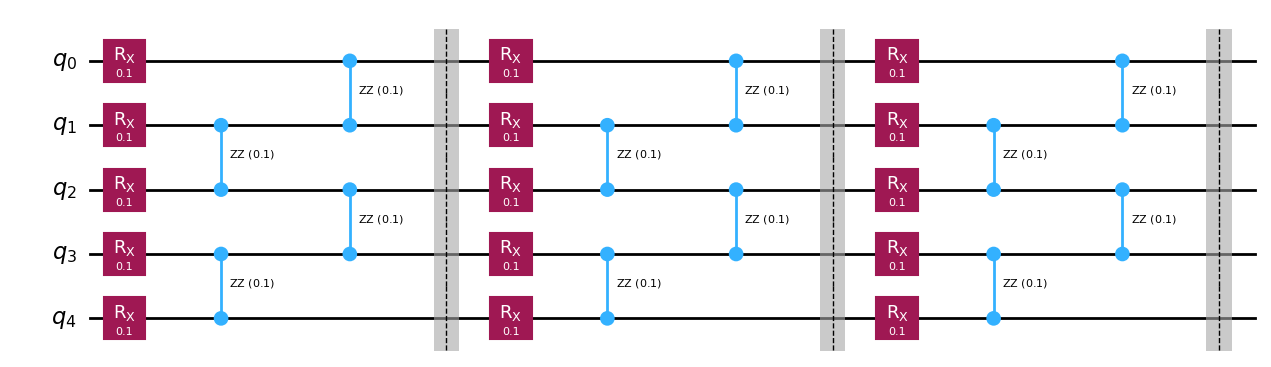

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization.timeline import draw as draw_timeline, IQXSimple

from qiskit_ibm_runtime import QiskitRuntimeService


num_qubits = 5
num_time_steps = 3
rx_angle = 0.1
rzz_angle = 0.1

ising_circuit = QuantumCircuit(num_qubits)
for i in range(num_time_steps):
    # rx layer
    for q in range(num_qubits):
        ising_circuit.rx(rx_angle, q)
    for q in range(1, num_qubits - 1, 2):
        ising_circuit.rzz(rzz_angle, q, q + 1)
    # 2nd rzz layer
    for q in range(0, num_qubits - 1, 2):
        ising_circuit.rzz(rzz_angle, q, q + 1)
    ising_circuit.barrier()
ising_circuit.draw("mpl")

Specify two backend objects: one with fractional gates enabled, and the other with them disabled, then transpile them both.

In [2]:
service = QiskitRuntimeService()
backend_fractional = service.backend("ibm_torino", use_fractional_gates=True)
backend_conventional = service.backend(
    "ibm_torino", use_fractional_gates=False
)

pm_fractional = generate_preset_pass_manager(
    optimization_level=3, backend=backend_fractional, scheduling_method="alap"
)
pm_conventional = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend_conventional,
    scheduling_method="alap",
)

ising_circuit_fractional = pm_fractional.run(ising_circuit)
ising_circuit_conventional = pm_conventional.run(ising_circuit)

Display the timeline of the circuit using the two types of gates.

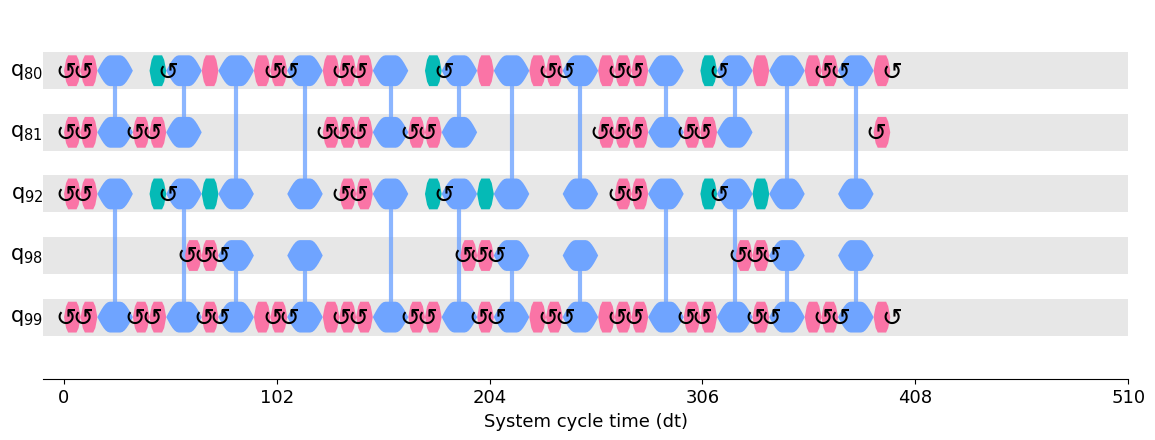

In [3]:
# Draw timeline of circuit with conventional gates
draw_timeline(
    ising_circuit_conventional,
    idle_wires=False,
    target=backend_conventional.target,
    time_range=(0, 500),
    style=IQXSimple(),
)

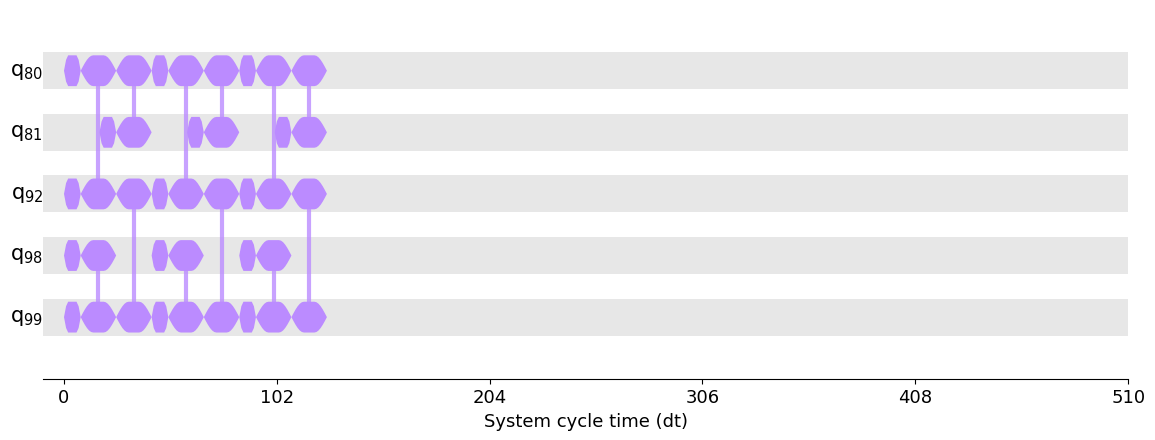

In [4]:
# Draw timeline of circuit with fractional gates
draw_timeline(
    ising_circuit_fractional,
    idle_wires=False,
    target=backend_fractional.target,
    time_range=(0, 500),
    style=IQXSimple(),
)

## Where to use fractional gates

Historically, the basis gates available on IBM Quantum QPUs have been **`CZ`**, **`X`**, **`RZ`**, **`SX`**, and **`ID`**, which can not efficiently represent circuits with single- and two-qubit rotations that are not multiples of $\pi / 2$. For example, an $R_X(\theta)$ gate, when transpiled, must decompose into a series of $RZ$ and $\sqrt{X}$ gates, which creates a circuit with two gates of finite duration instead of one.

Similarly, when two-qubit rotations such as an $R_{ZZ}(\theta)$ gate are transpiled, the decomposition requires two **`CZ`** gates and several single-qubit gates, which increases the circuit depth. These decompositions are shown in the following code.

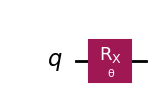

In [5]:
qc = QuantumCircuit(1)
param = Parameter("θ")
qc.rx(param, 0)
qc.draw("mpl")

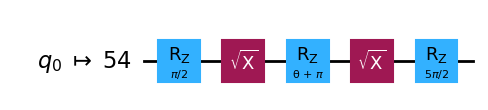

In [6]:
# Decomposition of an RX(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw("mpl", idle_wires=False)

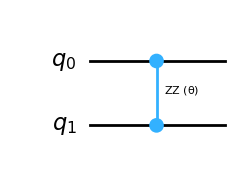

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService

qc = QuantumCircuit(2)
param = Parameter("θ")
qc.rzz(param, 0, 1)
qc.draw("mpl")

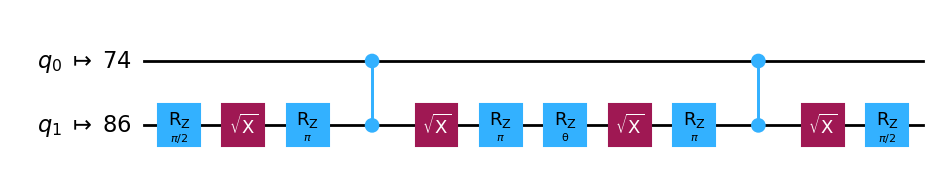

In [8]:
# Decomposition of an RZZ(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw("mpl", idle_wires=False)

For workflows that require many single-qubit $R_X(\theta)$ or two-qubit rotations (such as in a variational ansatz or when simulating the time evolution of quantum systems), this constraint causes the circuit depth to grow rapidly. However, fractional gates remove this requirement, because the single- and two-qubit rotations are executed directly, and create a more efficient (and thus error-suppressed) quantum circuit.

## When *not* to use fractional gates

It is important to note that fractional gates are an *experimental* feature and the behavior of the `use_fractional_gates` flag may change in the future. Look to the [release notes](/api/qiskit-ibm-runtime/release-notes) for new versions of Qiskit Runtime for more information. See also the API reference documentation for [QiskitRuntimeService.backend](/api/qiskit-ibm-runtime/qiskit-runtime-service#backend), which describes `use_fractional_gates`.

Additionally, the Qiskit transpiler has limited capability to use $R_{ZZ}(\theta)$ in its optimization passes. This requires you to take more care in crafting and optimizing circuits that contain these instructions.

Lastly, using fractional gates is not supported for:
- [Dynamic circuits](/guides/classical-feedforward-and-control-flow)
- [Pauli twirling](/guides/error-mitigation-and-suppression-techniques#pauli-twirling) - however, [measurement twirling with TREX](/guides/error-mitigation-and-suppression-techniques#twirled-readout-error-extinction-trex) *is* supported.
- [Probabilistic error cancellation](/guides/error-mitigation-and-suppression-techniques#probabilistic-error-cancellation-pec)
- [Zero-noise extrapolation (using probabilistic error amplification)](/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea)

Read the guide on [primitive options](/guides/runtime-options-overview) to learn more about customizing the error mitigation and suppression techniques for a given quantum workload.

## Next steps

<Admonition type="tip" title="Recommendations">
  -  To learn more about transpilation, see the [introduction to transpilation](/guides/transpile) page.
  -  Read about [writing a custom transpiler pass](/guides/custom-transpiler-pass).
  -  Understand how to [configure error mitigation](/guides/configure-error-mitigation) for Qiskit Runtime.
</Admonition>